In [98]:
import pandas as pd #v1.2.4
import numpy as np #1.21.5
from sklearn.decomposition import PCA  #python says this is at v0.0????????
import matplotlib.pyplot as plt #3.5.1
import seaborn as sns #0.11.2
sns.set_theme(style="darkgrid")

#imports for regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor #v1.5.0
from sklearn.model_selection import GridSearchCV 

#for feature importance
from sklearn.inspection import permutation_importance
import shap #https://github.com/slundberg/shap v0.41.0

randomState = 6164880

# import and pre-processing

Import data, and remove oddities such as , and . being switched, letter where numbers where expected, and convert everything to the right datatype

In [2]:
#import Data
data=pd.read_csv("data.tab", sep='\t', header=None, names = ["id", "runday", "country", "date", "new_deaths_smoothed_per_million", "stringency_index", "median_age", "gdp_per_capita", "tour_inc_gdp", "civilliberties", "trustp", "icu_bed", "lr", "plurality", "oppfrac", "govfrac", "checks"])


#Data cleaning
for col in data.columns.drop(['country', 'date']):
    data[col] = data[col].astype("string").str.replace(',','.').str.replace(r'[^0-9_._e_-]+', '') #remove non numeric characters in numeric columns and replace , with .
data = data.replace('', np.NaN)#replace empty cells by NaN



#leave the string columns, then convert other cols to int or float as needed.
for col in data.columns.drop(['country', 'date']):
    if col in ['id', 'runday', 'civilliberties', 'plurality', 'checks']:
        data[col] = data[col].astype("int")
    else:
        data[col] = data[col].astype("float")
data['country'] = data['country'].astype('string')


data = data.drop(['lr'], axis = 1)#lr is empty for Switzerland, so we drop it


data = data.sort_values(["id","runday"], axis = 0, ascending = True)#sort dataframe by country/id first and then by runday second which is neccesary for interpolation
# display(data.head(10))



The default value of regex will change from True to False in a future version.


This block is to check if NaNs are somewhat evenly distributed over the countries, which they seem to be

Removing NaNs

In [4]:
print(data.isna().sum()) #NaNs before

for col in data.columns:
    # display(data[col].dtype)
    if col in ['country','date', 'plurality', 'lr']: #would prefer to select on datatype, but those are a bit strange so I'll leave it hardcoded like this
        data[col] = data[col].interpolate('ffill') #interpolate non-numeric cols with forward fill
    else:
        data[col] = data[col].interpolate('linear') #interpolate numeric cols with linear interpolation
        
#the first 5 days of austria here here are empty, so linear interpolation doesnt work, therefore we interpolate this col again with backfill, since the deaths are 0 for a while anyway we can pretty safely assume this is correct
data['new_deaths_smoothed_per_million'] = data['new_deaths_smoothed_per_million'].interpolate('bfill')#the first 5 days of austria here here are empty, so linear interpolation doesnt work, therefore we interpolate this col again with backfill, since the deaths are 0 for a while anyway we can pretty safely assume this is correct



print(data.isna().sum()) #NaNs after


id                                   0
runday                               0
country                              0
date                                 0
new_deaths_smoothed_per_million    259
stringency_index                   197
median_age                           0
gdp_per_capita                       0
tour_inc_gdp                         0
civilliberties                       0
trustp                               0
icu_bed                              0
plurality                            0
oppfrac                              0
govfrac                              0
checks                               0
dtype: int64
id                                 0
runday                             0
country                            0
date                               0
new_deaths_smoothed_per_million    0
stringency_index                   0
median_age                         0
gdp_per_capita                     0
tour_inc_gdp                       0
civilliberties                

# first analysis/inspection
some basic statistics, visual inspection and PCA

In [5]:
data.describe()
data.head()

,id,runday,country,date,new_deaths_smoothed_per_million,stringency_index,median_age,gdp_per_capita,tour_inc_gdp,civilliberties,trustp,icu_bed,plurality,oppfrac,govfrac,checks
395,1,56,Austria,25-2-2020,0.0,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0,0.630643,0.396478,5
412,1,57,Austria,26-2-2020,0.0,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0,0.630643,0.396478,5
429,1,58,Austria,27-2-2020,0.0,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0,0.630643,0.396478,5
446,1,59,Austria,28-2-2020,0.0,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0,0.630643,0.396478,5
463,1,60,Austria,29-2-2020,0.0,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0,0.630643,0.396478,5


#### visualising all the per country means per variable

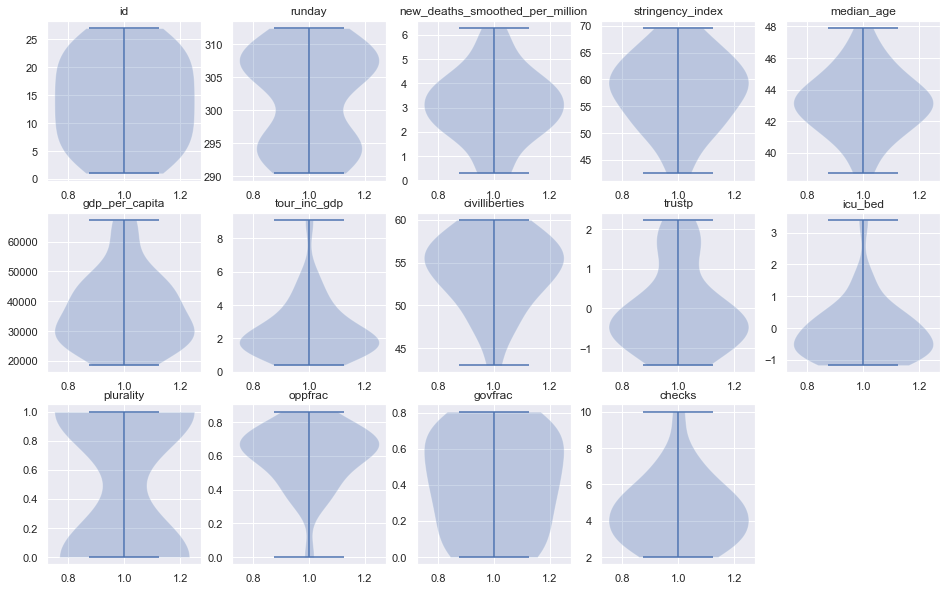

In [89]:
data_grouped = data.groupby("country")#.drop(['lr', 'plurality'], axis=1)
# display(data_grouped.mean())

plt.figure(figsize = (16,10))

for i,col in enumerate(data_grouped.mean(), 1):
    plt.subplot(3,5,i)
    plt.title(col)
    plt.violinplot(data_grouped.mean()[col])

plt.savefig('figures/violin.svg', bbox_inches='tight')

### PCA, first for one country, then for all

In [79]:
countryData = data[data['country'] == "Austria"]

# countryData.head()

countryData = countryData.drop(['country','date'],axis=1).dropna()
countryData.head()
# sns.lineplot(x="runday", y="new_deaths_smoothed_per_million", data=data)

,id,runday,new_deaths_smoothed_per_million,stringency_index,median_age,gdp_per_capita,tour_inc_gdp,civilliberties,trustp,icu_bed,plurality,oppfrac,govfrac,checks
395,1,56,0.0,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0,0.630643,0.396478,5
412,1,57,0.0,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0,0.630643,0.396478,5
429,1,58,0.0,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0,0.630643,0.396478,5
446,1,59,0.0,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0,0.630643,0.396478,5
463,1,60,0.0,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0,0.630643,0.396478,5


In [80]:
display(countryData.dtypes)
countryData.isnull().values.any()

id                                   int32
runday                               int32
new_deaths_smoothed_per_million    float64
stringency_index                   float64
median_age                         float64
gdp_per_capita                     float64
tour_inc_gdp                       float64
civilliberties                       int32
trustp                             float64
icu_bed                            float64
plurality                            int32
oppfrac                            float64
govfrac                            float64
checks                               int32
dtype: object

False

#### Z-score normalisation

In [81]:
# def absolute_maximum_scale(x): #no longer used
#     if x.max() == 0:
#         x_norm = x
#     else:
#         x_norm = x / x.max(axis=0)
#     return x_norm

def normalise_z_score(x): #simple own implementation works fine here, done by collumn because doing so on whole DF gave weird problems
    if np.std(x) == 0:
        x_norm = x - np.mean(x)
    else:
        x_norm = (x - np.mean(x)) / np.std(x)
    return x_norm


countryData_normalised = pd.DataFrame()
for col in countryData.columns:
    countryData_normalised[col] = normalise_z_score(countryData[col])

display(countryData_normalised.head(), countryData.describe(), countryData_normalised.describe())

,id,runday,new_deaths_smoothed_per_million,stringency_index,median_age,gdp_per_capita,tour_inc_gdp,civilliberties,trustp,icu_bed,plurality,oppfrac,govfrac,checks
395,0.0,-1.728604,-0.752837,-2.685762,-1.0,1.0,-1.0,0.0,-1.0,1.0,0.0,-1.0,1.0,0.0
412,0.0,-1.721703,-0.752837,-2.685762,-1.0,1.0,-1.0,0.0,-1.0,1.0,0.0,-1.0,1.0,0.0
429,0.0,-1.714803,-0.752837,-2.685762,-1.0,1.0,-1.0,0.0,-1.0,1.0,0.0,-1.0,1.0,0.0
446,0.0,-1.707902,-0.752837,-2.685762,-1.0,1.0,-1.0,0.0,-1.0,1.0,0.0,-1.0,1.0,0.0
463,0.0,-1.701001,-0.752837,-2.685762,-1.0,1.0,-1.0,0.0,-1.0,1.0,0.0,-1.0,1.0,0.0


,id,runday,new_deaths_smoothed_per_million,stringency_index,median_age,gdp_per_capita,tour_inc_gdp,civilliberties,trustp,icu_bed,plurality,oppfrac,govfrac,checks
count,502.0,502.000000,502.000000,502.000000,5.020000e+02,5.020000e+02,5.020000e+02,502.0,5.020000e+02,5.020000e+02,502.0,5.020000e+02,5.020000e+02,502.0
mean,1.0,306.500000,2.370896,61.777361,4.440000e+01,4.543669e+04,4.400000e+00,56.0,7.891954e-02,1.541315e+00,0.0,6.306430e-01,3.964777e-01,5.0
std,0.0,145.059183,3.152425,18.883992,1.991504e-13,2.184965e-11,4.089696e-14,0.0,5.417736e-16,7.334781e-15,0.0,1.889262e-15,1.778129e-15,0.0
min,1.0,56.000000,0.000000,11.110000,4.440000e+01,4.543669e+04,4.400000e+00,56.0,7.891954e-02,1.541315e+00,0.0,6.306430e-01,3.964777e-01,5.0
25%,1.0,181.250000,0.174000,41.670000,4.440000e+01,4.543669e+04,4.400000e+00,56.0,7.891954e-02,1.541315e+00,0.0,6.306430e-01,3.964777e-01,5.0
50%,1.0,306.500000,0.952000,68.520000,4.440000e+01,4.543669e+04,4.400000e+00,56.0,7.891954e-02,1.541315e+00,0.0,6.306430e-01,3.964777e-01,5.0
75%,1.0,431.750000,3.125000,77.543750,4.440000e+01,4.543669e+04,4.400000e+00,56.0,7.891954e-02,1.541315e+00,0.0,6.306430e-01,3.964777e-01,5.0
max,1.0,557.000000,14.355000,82.410000,4.440000e+01,4.543669e+04,4.400000e+00,56.0,7.891954e-02,1.541315e+00,0.0,6.306430e-01,3.964777e-01,5.0


,id,runday,new_deaths_smoothed_per_million,stringency_index,median_age,gdp_per_capita,tour_inc_gdp,civilliberties,trustp,icu_bed,plurality,oppfrac,govfrac,checks
count,502.0,5.020000e+02,5.020000e+02,5.020000e+02,502.0,502.0,502.0,502.0,502.0,502.0,502.0,502.0,502.0,502.0
mean,0.0,1.946208e-17,-8.001568e-16,7.537132e-16,-1.0,1.0,-1.0,0.0,-1.0,1.0,0.0,-1.0,1.0,0.0
std,0.0,1.000998e+00,1.000998e+00,1.000998e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,-1.728604e+00,-7.528368e-01,-2.685762e+00,-1.0,1.0,-1.0,0.0,-1.0,1.0,0.0,-1.0,1.0,0.0
25%,0.0,-8.643020e-01,-6.975861e-01,-1.065846e+00,-1.0,1.0,-1.0,0.0,-1.0,1.0,0.0,-1.0,1.0,0.0
50%,0.0,0.000000e+00,-4.505458e-01,3.574120e-01,-1.0,1.0,-1.0,0.0,-1.0,1.0,0.0,-1.0,1.0,0.0
75%,0.0,8.643020e-01,2.394524e-01,8.357405e-01,-1.0,1.0,-1.0,0.0,-1.0,1.0,0.0,-1.0,1.0,0.0
max,0.0,1.728604e+00,3.805343e+00,1.093689e+00,-1.0,1.0,-1.0,0.0,-1.0,1.0,0.0,-1.0,1.0,0.0


### actual pca of single country, and showing loadings, most are zero as the std of many variables is 0 for a sigle country

We find only first 3 pc's explain variance, because only 3 variable actually change over time, since this is per country some variables are constant and explain no variance

In [87]:
pca = PCA(n_components = 4)
pca.fit(countryData_normalised)
countryData_transformed = pca.transform(countryData_normalised)

loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4'], index=countryData_normalised.columns)
display(pca.explained_variance_ratio_,loadings)

array([0.61462947, 0.24926347, 0.13610706, 0.        ])

,PC1,PC2,PC3,PC4
id,0.000000,-0.000000,-0.000000,0.0
runday,-0.485604,0.863561,0.135830,0.0
new_deaths_smoothed_per_million,-0.604599,-0.444000,0.661305,0.0
stringency_index,-0.631386,-0.239010,-0.737717,0.0
median_age,0.000000,-0.000000,-0.000000,0.0
gdp_per_capita,0.000000,-0.000000,-0.000000,0.0
tour_inc_gdp,0.000000,-0.000000,-0.000000,1.0
civilliberties,0.000000,-0.000000,-0.000000,0.0
trustp,0.000000,-0.000000,-0.000000,0.0
icu_bed,0.000000,-0.000000,-0.000000,0.0


Text(0, 0.5, 'Second Principal Component')

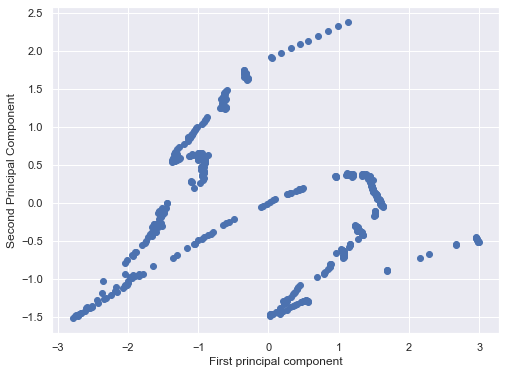

In [88]:
plt.figure(figsize=(8,6))
plt.scatter(countryData_transformed[:,0],countryData_transformed[:,1])
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')


Now do pca in a loop for each country, colored by some variable, now runday

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


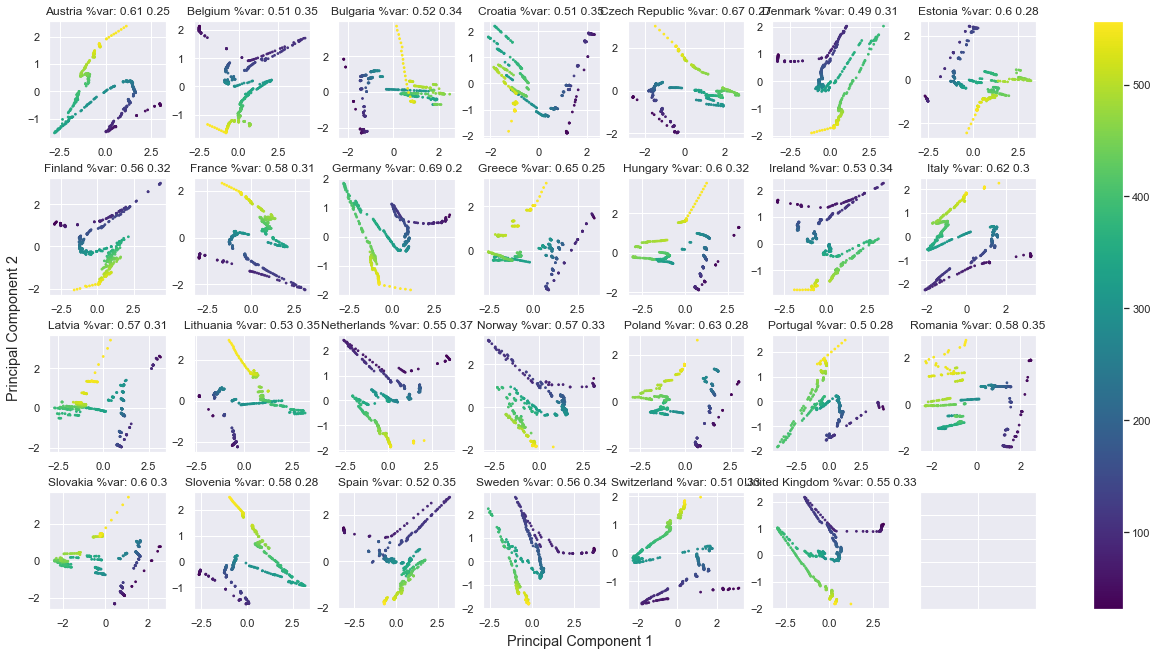

In [75]:
fig, axes = plt.subplots(nrows=4, ncols=7, figsize = (16,9), constrained_layout=True)#create figure

for i, country in enumerate(np.unique(data["country"])):#loop through countries
    countryData = data.loc[data['country'] == country]#select data for single country
    countryData = countryData.drop(['country', 'date'],axis=1).dropna()#remove non numeric cols
    
    
    #normalise data and add to new df
    countryData_normalised = pd.DataFrame()
    for col in countryData.columns:
        countryData_normalised[col] = normalise_z_score(countryData[col].astype(float))

    #create PCA object and fit it
    pca = PCA(n_components = 2)
    pca.fit(countryData_normalised)
    countryData_transformed = pca.transform(countryData_normalised)
    
    #make subplot for country
    ax = axes.flat[i]
    coloring = np.array(countryData['runday']).reshape(countryData['runday'].size,1)#what variable to color PCA plot by
    countryData_transformed = np.append(countryData_transformed, coloring, axis=1)
    points = ax.scatter(countryData_transformed[:,0], countryData_transformed[:,1], s = 3, c=coloring, cmap='viridis')
    
    #uncomment end of line to eadd explained variance
    ax.title.set_text(str(country) + " %var: " + str(round(pca.explained_variance_ratio_[0],2)) + " " + str(round(pca.explained_variance_ratio_[1],2)))
    
#set all globa plot labels etc and save
fig.supxlabel('Principal Component 1')
fig.supylabel('Principal Component 2')
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.colorbar(points, ax=axes.ravel().tolist())
plt.savefig('figures/perCountryPCA.svg', bbox_inches='tight')

## PCA for all countries together

In [13]:
data.head()
data_normalised = pd.DataFrame()
for col in data.columns:
    if col in data.drop(['id','country', 'date'],axis=1): #only take numerical collumns, except ID since it is catagorical
        data_normalised[col] = normalise_z_score(data[col])
        
data_normalised.describe()

,runday,new_deaths_smoothed_per_million,stringency_index,median_age,gdp_per_capita,tour_inc_gdp,civilliberties,trustp,icu_bed,plurality,oppfrac,govfrac,checks
count,1.379000e+04,1.379000e+04,1.379000e+04,1.379000e+04,1.379000e+04,1.379000e+04,1.379000e+04,1.379000e+04,1.379000e+04,1.379000e+04,1.379000e+04,1.379000e+04,1.379000e+04
mean,-4.601911e-17,-8.839501e-15,-3.169618e-15,-6.604116e-13,5.429694e-14,1.842798e-13,-6.628040e-15,-1.943655e-15,2.646783e-14,7.553832e-15,-2.495855e-13,3.008353e-14,9.033778e-15
std,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00
min,-2.001010e+00,-1.806989e+00,-3.111266e+00,-2.216760e+00,-1.514051e+00,-1.207225e+00,-2.623356e+00,-1.398958e+00,-1.134475e+00,-1.037693e+00,-3.252843e+00,-1.549836e+00,-1.377785e+00
25%,-8.648564e-01,-6.554765e-01,-5.722657e-01,-7.040196e-01,-8.110274e-01,-6.569319e-01,-4.932213e-01,-7.696198e-01,-7.745782e-01,-1.037693e+00,-6.199578e-01,-7.766693e-01,-8.502657e-01
50%,7.846638e-04,-4.803679e-01,9.985416e-02,-2.084623e-02,-2.377698e-01,-4.368147e-01,2.168238e-01,-2.451714e-01,-2.738525e-01,9.636759e-01,2.118778e-01,1.154881e-01,-3.227467e-01
75%,8.664257e-01,3.079566e-01,7.225060e-01,6.135290e-01,6.692757e-01,4.986838e-01,6.901871e-01,2.792770e-01,4.928837e-01,9.636759e-01,7.086073e-01,1.029890e+00,7.322912e-01
max,1.725304e+00,5.737444e+00,2.066746e+00,2.272664e+00,2.448428e+00,3.580325e+00,1.400232e+00,2.167291e+00,3.512886e+00,9.636759e-01,1.420297e+00,1.492558e+00,2.842367e+00


In [14]:
#do pca on whole dataset with all countries
pca = PCA(n_components = 2)
pca.fit(data_normalised)
data_transformed = pca.transform(data_normalised)
display(pca.explained_variance_ratio_, pca.explained_variance_)

loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=data_normalised.columns)
display(loadings)

array([0.29149288, 0.13329725])

array([3.78968219, 1.73298987])

,PC1,PC2
runday,-0.023975,-0.184725
new_deaths_smoothed_per_million,-0.144451,-0.287027
stringency_index,-0.047669,-0.291970
median_age,-0.263426,0.372541
gdp_per_capita,0.425784,-0.171303
tour_inc_gdp,-0.159222,0.472721
civilliberties,0.443059,0.182186
trustp,0.418862,0.017023
icu_bed,-0.142927,-0.139598
plurality,-0.338916,-0.214414


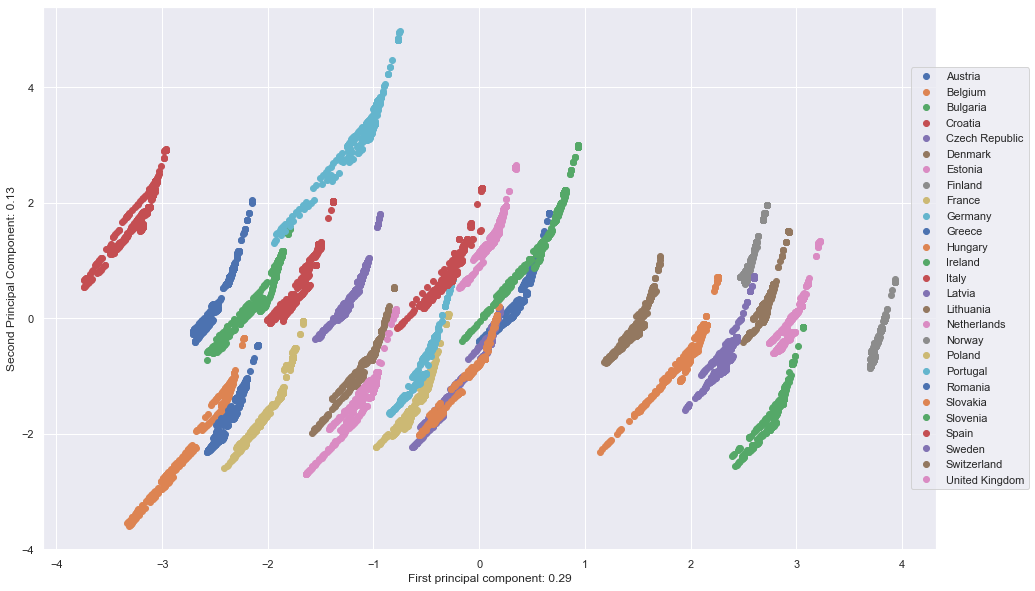

In [15]:
plt.figure(figsize=(16,10))

coloring = np.array(data['country']).reshape(data['country'].size,1) #re add country labels after pca so we can color by country
data_transformed2 = np.append(data_transformed, coloring, axis=1)

countries = pd.DataFrame(data_transformed2, columns=['pc1', 'pc2', 'country']).groupby('country')
for name, group in countries:
    plt.plot(group.iloc[:,0],group.iloc[:,1], marker='o', linestyle='', label=name)
plt.xlabel('First principal component: ' + str(round(pca.explained_variance_ratio_[0],2)))
plt.ylabel('Second Principal Component: '+ str(round(pca.explained_variance_ratio_[1],2)))
plt.legend(bbox_to_anchor=(1.11,0.5),loc = 'right')
plt.savefig('figures/allCountryPCA.svg', bbox_inches='tight')

In [16]:
data.isnull().values.any()
print(data.isna().sum()) 

id                                 0
runday                             0
country                            0
date                               0
new_deaths_smoothed_per_million    0
stringency_index                   0
median_age                         0
gdp_per_capita                     0
tour_inc_gdp                       0
civilliberties                     0
trustp                             0
icu_bed                            0
plurality                          0
oppfrac                            0
govfrac                            0
checks                             0
dtype: int64


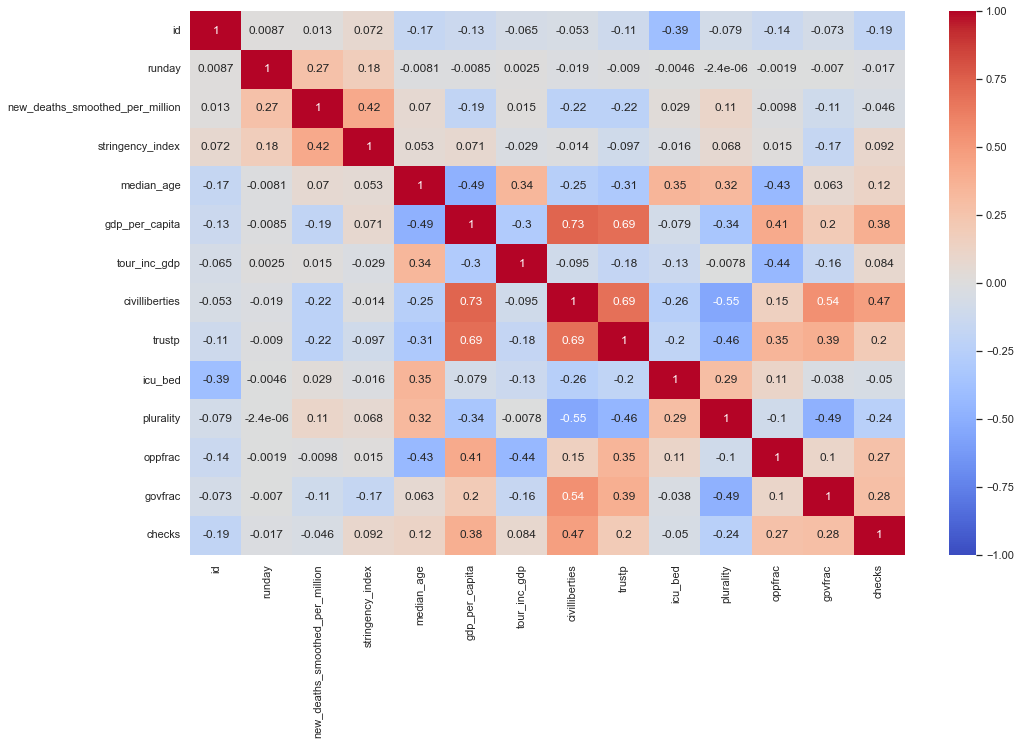

In [17]:
sns.set(rc = {'figure.figsize':(16, 10)})
dataplot = sns.heatmap(data.corr(), cmap="coolwarm", annot=True, vmin=-1, vmax=1)
plt.savefig('figures/correlations.svg', bbox_inches='tight')

## Reegression methods, predicting covid deaths

Linear regression first
This includes splitting the data into train and test set that will be used by all regressors

In [56]:
X = data_normalised.drop(['new_deaths_smoothed_per_million'],axis=1)
y = data_normalised['new_deaths_smoothed_per_million']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.15, shuffle=True, random_state=randomState)

In [61]:
model = LinearRegression().fit(X_train, y_train)
score = model.score(X_test, y_test)
score2 = mean_squared_error(model.predict(X_test), y_test)
display(score, X, y)

0.25294758081111557

,runday,stringency_index,median_age,gdp_per_capita,tour_inc_gdp,civilliberties,trustp,icu_bed,plurality,oppfrac,govfrac,checks
395,-1.662869,-2.513885,0.564731,0.669276,0.993948,0.453505,0.069498,1.619517,-1.037693,0.166552,-0.051855,0.204772
412,-1.656106,-2.513885,0.564731,0.669276,0.993948,0.453505,0.069498,1.619517,-1.037693,0.166552,-0.051855,0.204772
429,-1.649344,-2.513885,0.564731,0.669276,0.993948,0.453505,0.069498,1.619517,-1.037693,0.166552,-0.051855,0.204772
446,-1.642581,-2.513885,0.564731,0.669276,0.993948,0.453505,0.069498,1.619517,-1.037693,0.166552,-0.051855,0.204772
463,-1.635818,-2.513885,0.564731,0.669276,0.993948,0.453505,0.069498,1.619517,-1.037693,0.166552,-0.051855,0.204772
...,...,...,...,...,...,...,...,...,...,...,...,...
12337,1.698253,-0.323312,-1.094404,0.792166,0.003420,1.400232,1.433063,-0.884112,-1.037693,1.055316,-0.643515,-0.322747
12355,1.705016,-0.323312,-1.094404,0.792166,0.003420,1.400232,1.433063,-0.884112,-1.037693,1.055316,-0.643515,-0.322747
12373,1.711778,-0.323312,-1.094404,0.792166,0.003420,1.400232,1.433063,-0.884112,-1.037693,1.055316,-0.643515,-0.322747
12391,1.718541,-0.323312,-1.094404,0.792166,0.003420,1.400232,1.433063,-0.884112,-1.037693,1.055316,-0.643515,-0.322747


395     -0.696626
412     -0.696626
429     -0.696626
446     -0.696626
463     -0.696626
           ...   
12337   -0.674486
12355   -0.665093
12373   -0.658607
12391   -0.658607
12409   -0.658607
Name: new_deaths_smoothed_per_million, Length: 13790, dtype: float64



Lasso and ridge regression to see if that improves performance

In [19]:
#define cross-validation method to evaluate models
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=randomState)

#define model
lassoModel = LassoCV(alphas=np.arange(0.001, 1, 0.01), cv=cv, n_jobs=-2, random_state=randomState)

#fit model
lassoModel.fit(X_train, y_train)

lassoScore = lassoModel.score(X_test, y_test)
lassoScore2 = mean_squared_error(lassoModel.predict(X_test), y_test)
print("alpha: ", lassoModel.alpha_, " score: ", lassoScore)

alpha:  0.001  score:  0.2532977434598709


In [20]:
#define model
ridgeModel = RidgeCV(alphas=np.arange(0.01, 1, 0.01), cv=cv)

#fit model
ridgeModel.fit(X_train, y_train)

ridgeScore = ridgeModel.score(X_test, y_test) #R2 score
ridgeScore2 = mean_squared_error(ridgeModel.predict(X_test), y_test) #MSE
#display lambda that produced the lowest test MSE
print("alpha: ", ridgeModel.alpha_, " score: ", ridgeScore)

alpha:  0.99  score:  0.25294829027069143


#### nonlinear regression methods
First Support vector regression, we then try to find optimal parameters with gridsearch cross validation

In [21]:
SVRModel = SVR(kernel='rbf', gamma = 2.0, C=1000) #best parameters calculated though gridsearch below
SVRModel.fit(X_train,y_train)

#test model performance
SVRScore = SVRModel.score(X_test, y_test) #R2 score
SVRScore2 = mean_squared_error(SVRModel.predict(X_test), y_test) #MSE
print("score: ", SVRScore, SVRScore2)

score:  0.9642299838614867 0.03843996742437935


Warning! GridSearch can take very long to run!

Test many parameter combinations through cross validation and output best one

In [ ]:
# defining parameter range 
param_grid = {'C': [750, 1000, 1250],  #already tried lower values, they performed worse
              'gamma': [1.5,2.0,2.5], 
              # 'gamma':['scale', 'auto'],
              'kernel': ['rbf']}  
   
SVRGrid = GridSearchCV(SVR(), param_grid, refit = True, verbose = 3,n_jobs=-2, cv=10) 
SVRGrid.fit(X_train,y_train)

In [ ]:
# print best parameter after tuning 
print(SVRGrid.best_params_) 

SVRGridScore = SVRGrid.score(X_test, y_test)
SVRGridScore2 = mean_squared_error(SVRGrid.predict(X_test), y_test)
print("score: ", SVRGridScore, SVRGridScore2)

Now try random forst models and again use gridsearch CV

In [64]:
# create regressor object
treeModel = RandomForestRegressor(max_features='log2', n_estimators=300, random_state = randomState) #best parameters calculated though gridsearch below
  
# fit the regressor with x and y data
treeModel.fit(X_train, y_train) 

treeScore = treeModel.score(X_test, y_test)
treeScore2 = mean_squared_error(treeModel.predict(X_test), y_test)
#display lambda that produced the lowest test MSE
print("score: ", treeScore, treeScore2)




score:  0.9937714926657029 0.006693416578448415


Warning! GridSearch can take very long to run!

In [ ]:
param_grid = {'n_estimators': [250,300],  
              'max_features': ['sqrt', 'log2', 'auto'],
              # 'criterion': ['squared_error', 'absolute_error'],#absolute error is a lot slow, be cautious
             'min_samples_split': [2,3,5],
             'min_samples_leaf': [1,2,3]
             }
   
treeGrid = GridSearchCV(RandomForestRegressor(random_state = randomState), param_grid, refit = True, verbose = 3, n_jobs=-2, cv=10) 
treeGrid.fit(X_train,y_train)


# print best parameter after tuning 
print(treeGrid.best_params_) 

treeGridScore = treeGrid.score(X_test, y_test)
treeGridScore2 = mean_squared_error(treeGrid.predict(X_test), y_test)
print("score: ", treeGridScore, treeGridScore2)
# grid_predictions = grid.predict(X_test) 
   
# print classification report 
# print(classification_report(y_test, grid_predictions)) 

eXtreme Gradient Boosting seems not neccesary because normal RF already performs more than well enough

In [23]:
coefficients = pd.DataFrame(np.stack((model.coef_, lassoModel.coef_, ridgeModel.coef_), axis = 0).T, columns=['linear', 'lasso', 'ridge'], index=X.columns)
scores = [score, lassoScore, ridgeScore, SVRScore, treeScore] #r2 scores
scores2 = [score2, lassoScore2, ridgeScore2, SVRScore2, treeScore2] #mse scores

scoreDF = pd.DataFrame(np.stack([scores,scores2]).T, index=['linear', 'lasso', 'ridge', 'svr', 'rf'], columns = ["scores",'MSE'])
display(coefficients, scoreDF)

,linear,lasso,ridge
runday,0.196838,0.196160,0.196829
stringency_index,0.401360,0.399360,0.401314
median_age,-0.082269,-0.074950,-0.082205
gdp_per_capita,-0.158588,-0.154433,-0.158534
tour_inc_gdp,0.012993,0.010203,0.012986
civilliberties,-0.149069,-0.147175,-0.149032
trustp,-0.043078,-0.044898,-0.043122
icu_bed,0.006930,0.004084,0.006910
plurality,0.012680,0.008913,0.012660
oppfrac,0.037298,0.038302,0.037323


,scores,MSE
linear,0.252948,0.802814
lasso,0.253298,0.802438
ridge,0.252948,0.802813
svr,0.964230,0.038440
rf,0.993771,0.006693


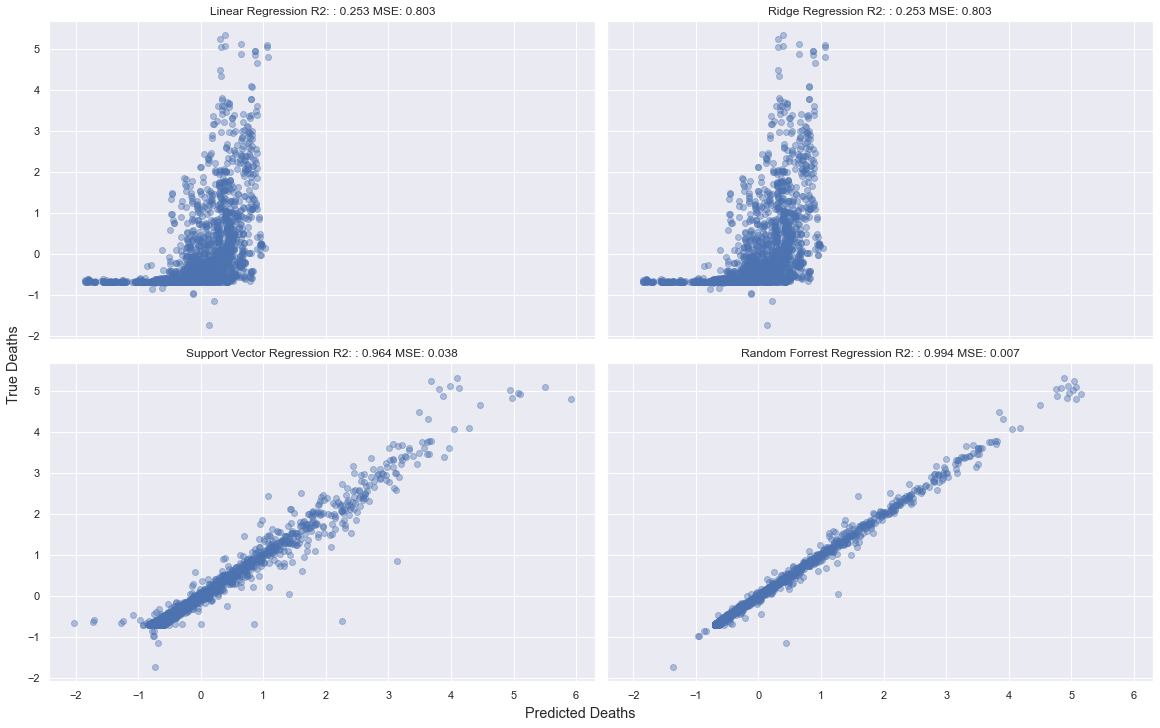

In [59]:
models = [model, ridgeModel, SVRModel, treeModel]
modelNames = ['Linear', 'Ridge', 'Support Vector', 'Random Forrest']
plotScores = np.round([[score, ridgeScore, SVRScore, treeScore], [score2, ridgeScore2, SVRScore2, treeScore2]],3)#r2 scores for models in plot

fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (16,10),constrained_layout=True,sharex=True, sharey=True)
for i, regModel in enumerate(models):
    ax = axes.flat[i]
    ax.scatter(regModel.predict(X_test), y_test, alpha = 0.4, cmap='viridis')
    ax.title.set_text(modelNames[i] + ' Regression R2: : ' + str(plotScores[0][i]) + " MSE: " + str(plotScores[1][i]))

fig.supxlabel('Predicted Deaths')
fig.supylabel('True Deaths')
plt.savefig('figures/realVsPredicted.svg', bbox_inches='tight')

# Feature importance
This is done first for rf through its inbuilt feature importance, and then through shapley values for the SVR and RF models

In [57]:
feat_importances = pd.Series(treeModel.feature_importances_, index=X.columns)
# feat_importances.nlargest(12).plot(kind='barh')

In [26]:
# explainer_SVR = shap.Explainer(SVRModel) #does not work because model is not callable and cannot be analyzed directly with the given masker!
# shap_values_SVR = explainer.shap_values(X_test)

explainer = shap.TreeExplainer(treeModel)
shap_values = explainer.shap_values(X_test)

# shap.summary_plot(shap_values, X_test, plot_type="bar")

In [27]:
shap_importances = np.abs(np.mean(shap_values, axis=0))
shap_importances

array([0.01512454, 0.01469466, 0.00524643, 0.00662535, 0.00155648,
       0.00128494, 0.00498232, 0.00124348, 0.00166656, 0.00184341,
       0.00321123, 0.0002847 ])

In [28]:
# perm_importance_SVR = permutation_importance(SVRModel, X_test, y_test) #seems to not work cause model is not callable?
perm_importance = permutation_importance(treeModel, X_test, y_test)


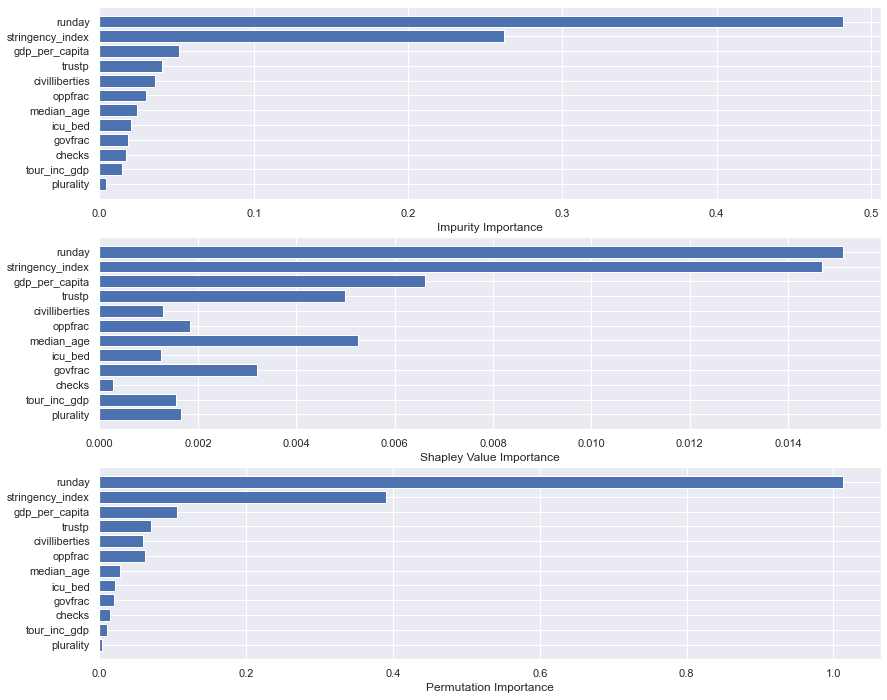

In [48]:
sorted_idx = treeModel.feature_importances_.argsort()#sort all by inbuilt/impurity based feature importances

plt.figure(figsize = (14,12))
plt.subplot(3,1,1)
plt.barh(X.columns[sorted_idx], treeModel.feature_importances_[sorted_idx])
plt.xlabel("Impurity Importance")
plt.subplot(3,1,2)
plt.barh(X.columns[sorted_idx], shap_importances[sorted_idx])
plt.xlabel("Shapley Value Importance")
plt.subplot(3,1,3)
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

plt.savefig('figures/featureImportances.svg', bbox_inches='tight')